In [3]:
import numpy as np
import torch
from functools import partial
import torch.nn as nn
# from model.archi_Former import MM_Former

KeyboardInterrupt: 

In [ ]:
MRM_dict=torch.load('C:/Users/Alex/Downloads/MRM.pth',map_location='cpu')
# ALB_dict=torch.load('C:/Users/Alex/Downloads/ALBEF.pth',map_location='cpu')
# model = MM_Former(patch_size=16, in_chans=3, embed_dim=768, depth=12, num_heads=12,
#         decoder_embed_dim=768, decoder_depth=4, decoder_num_heads=6,
#         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), norm_pix_loss=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 
# 
# # For a model
# model = model.to(device)

In [ ]:
# MRM
for key,v in MRM_dict['model'].items():
    print(key)
    print(MRM_dict['model'][key].shape)


In [ ]:
# MM
state_dict = model.state_dict()
# 打印所有键
for key in state_dict.keys():
    print(key)
    print(state_dict[key].shape)

In [ ]:
# ALBEF
for key in ALB_dict['model'].keys():
    print(key)
    print(ALB_dict['model'][key].shape)

In [ ]:
updated_dict = {}
# load from MRM
for key in state_dict.keys():
    if key.startswith('decoder_'):
        updated_dict[key]=MRM_dict['model'][key]
    # elif key.startswith('bert_encoder.bert.pooler'):
    #     new_key= key.replace('bert_encoder.bert.pooler', 'bert_encoder.model.bert.pooler')
    #     updated_dict[key]=MRM_dict['model'][new_key]
    # elif key.startswith('bert_encoder.cls.predictions'):
    #     new_key= key.replace('bert_encoder.cls.predictions', 'bert_encoder.model.cls.predictions')
    #     updated_dict[key]=MRM_dict['model'][new_key]
        

# load from ALBEF
for key in state_dict.keys():
    # 修改键名以匹配模型中的对应层
    if key.startswith('vision_proj') or key.startswith('text_proj'):
        updated_dict[key]=ALB_dict['model'][key]
    if key.startswith('blocks'): 
        new_key = key.replace('blocks','visual_encoder.blocks')
        updated_dict[key] = ALB_dict['model'][new_key]
    elif key.startswith('norm'):
        new_key = key.replace('norm','visual_encoder.norm', )
        updated_dict[key] = ALB_dict['model'][new_key]
    # elif key.startswith('bert_encoder.bert.embeddings'):
    #     new_key = key.replace('bert_encoder.bert.embeddings', 'text_encoder.bert.embeddings')
    elif key.startswith('bert_encoder.bert.encoder.layer'):
        layer_num = int(key.split('.')[4])
        new_key = key.replace(f'bert_encoder.bert.encoder.layer.{layer_num}',f'text_encoder.bert.encoder.layer.{layer_num}')
        updated_dict[key] = ALB_dict['model'][new_key]
    elif key.startswith('fusion_encoder.bert.encoder.layer'):
        layer_num = int(key.split('.')[4])
        new_key = key.replace(f'fusion_encoder.bert.encoder.layer.{layer_num}', f'text_encoder.bert.encoder.layer.{layer_num+6}')
        updated_dict[key] = ALB_dict['model'][new_key]
    # load bert.pooler and cls:
    elif key.startswith('fusion_encoder.cls.predictions'):
        new_key = key.replace('fusion_encoder.cls.predictions', 'text_encoder.cls.predictions')
        updated_dict[key] = ALB_dict['model'][new_key]
    elif key.startswith('bert_encoder.bert.embeddings'):
        new_key= key.replace('bert_encoder.bert.embeddings', 'text_encoder.bert.embeddings')
        updated_dict[key]=ALB_dict['model'][new_key]
    elif key.startswith('temp'):
        updated_dict['temp']=ALB_dict['model']['temp']
    

In [ ]:
# 将 state_dict 加载到模型中，strict 设置为 False 允许不匹配的键
load_result = model.load_state_dict(updated_dict, strict=False)

# load_state_dict 返回一个字典，包含 'missing_keys' 和 'unexpected_keys'
missing_keys = load_result.missing_keys
unexpected_keys = load_result.unexpected_keys
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

In [ ]:
save={}
save['model']=model.state_dict()
torch.save(save,'C:/Users/Alex/Downloads/MM.pth')

In [ ]:
from classification.model_ViT import MyViTClassifier
model=MyViTClassifier()
# print model state_dict
for key in model.state_dict().keys():
    print(key)

In [ ]:
import os
import csv

# Paths to your directories (adjust as necessary)
base_dir = '/home/data/Jingkai/alex/mimic/files'
# Path for the output CSV file
output_csv_path = 'training.csv'
def find_final_report(content):
    # Search for the start of the final report
    start_index = content.find('FINAL REPORT')
    if start_index != -1:
        # Return the content from 'FINAL REPORT' onwards
        return content[start_index:]
    else:
        # If 'FINAL REPORT' not found, return None or empty string
        return None
# Open the CSV file for writing
with open(output_csv_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['image_path', 'report_content'])
    
    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        for file_name in files:
            if file_name.endswith('.jpg'):
                # Construct the full path to the image
                image_path = os.path.join(root, file_name)
                
                # Change the extension from .jpg to .txt to find the corresponding report
                report_filename = os.path.splitext(image_path)[0] + '.txt'
                report_path = os.path.join(root, report_filename)
                
                # Read the report content
                try:
                    with open(report_path, 'r', encoding='utf-8') as report_file:       
                        report_content = report_file.read()
                        # Find and extract 'FINAL REPORT' content
                        final_report_content = find_final_report(report_content)
                        if final_report_content:
                            # Replace newlines with spaces
                            final_report_content = final_report_content.replace('\n', ' ').strip()
                            # Write the image path and processed report content to the CSV
                            writer.writerow([image_path, final_report_content])
                        else:
                            print(f"'FINAL REPORT' not found in: {report_filename}")
                        
                except FileNotFoundError:
                    print(f"Report file not found for image: {file_name}")

print("CSV file has been created.")


In [ ]:
from model.archi_Former import MM_Former
import torch
from model.archi import MM
from functools import partial
import torch.nn as nn
fake_images = torch.rand(2, 3, 448, 448)  # 模拟图像数据
text= ['sadflj123','231']
batch= {
    'image1': fake_images,
    'text': text

}
model = MM_Former(patch_size=16, in_chans=3, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=768, decoder_depth=4, decoder_num_heads=6,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), norm_pix_loss=True,local_contrastive_loss=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For a model
model = model.to(device)

# 将模型转换为评估模式（这对于某些模块如Dropout和BatchNorm很重要）
model.eval()

# 前向传播
with torch.no_grad():  # 不计算梯度，减少内存/计算需求
    output = model(batch)

# 检查输出
print(output[1].shape)
print(output[2].shape)

In [ ]:
from transformers import BertTokenizer

# 初始化tokenizer
tokenizer = BertTokenizer.from_pretrained('./model/submodule/bert/bert-base-uncased')
tokenizer.add_special_tokens({"bos_token": "[DEC]"})
# 
# # 示例文本
# text = "Here is some example text to tokenize."
# 
# # 对文本进行编码
encoded_input = tokenizer(['23[SEP]'], truncation=True, padding=True, max_length=1, return_tensors="pt")
# # print("Encoded Token IDs:", encoded_input)
# e=encoded_input.input_ids
# # 将编码后的token IDs转换回字符串
# tokens = tokenizer.convert_ids_to_tokens(e[0])
# print("Tokens:", tokens)
# 
# for i,j in zip(tokens,range(len(tokens))):
#     # make i the string
#     print(i,j)
print(tokenizer.bos_token_id)

In [ ]:
import os
import pandas as pd

data_root='C:/Users/Alex/Desktop'
csv_path=os.path.join(data_root,'training_mv.csv')
df = pd.read_csv(csv_path, sep=',')
i,vt,re=df["image_path"], df['view_type'], df["report_content"]



In [ ]:
import torch
blip=torch.load('/home/data/Jingkai/alex/weight/blip2_pretrained.pth',map_location='cpu')
# blip1=torch.load('C:/Users/Alex/Downloads/eva_vit_g.pth',map_location='cpu')
for key in blip['model'].keys():
    print(key)
    print(blip['model'][key].shape)
# blip1=blip1['model']
# print('##################')
# for key in blip1.keys():
#     print(key)
#     print(blip1[key].shape)

In [ ]:
import numpy as np

result=np.load(r'C:\Users\Alex\Desktop\result.npy',allow_pickle=True)
i2t=result.item().get('i2t')
t2i=result.item().get('t2i')
# get the variance of each line
i2t_var= np.var(i2t, axis=1)
t2i_var= np.var(t2i, axis=1)

In [ ]:
# MRM
for key in MRM_dict['model'].keys():
    print(key)
    print(MRM_dict['model'][key].shape)

In [ ]:
from model.submodule.vit.vit import get_ViT
model= get_ViT(vit_path=r'C:\Users\Alex\Downloads\deit_base_patch16_224.pth')
# print model weight shape
for key in model.state_dict().keys():
    print(key)
    print(model.state_dict()[key].shape)

In [ ]:
import os
import shutil
import csv
import pandas as pd
# read csv file
c=pd.read_csv('training.csv')
def get_images_captions(caption_file):
    captions = []
    images= []
    with open(caption_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                image_id, caption = parts
                captions.append(caption)
                images.append(str(image_id))
            else:
                print('Error: ', line)
                images.append(str(image_id))
                captions.append('')
    return images, captions

def save_to_csv(image_paths, texts, output_csv):
    with open(output_csv, 'a+', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        for img_path, text in zip(image_paths, texts):
            if text.strip()!='':
                writer.writerow([img_path+'.jpg', text])


def read_txt_to_lists(file_path):
    dict={}
    
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # 跳过标题行
        for row in reader:
            if len(row) != 3:
                print(row[0], row[1])
            else:
                dict[row[0]] = row[1]
    
    return dict

path=''
folder= ['validation']
type= ['radiology']
captions = []
images= []
dict= {}
for f in folder:
    for t in type:
        lic= os.path.join(path,f,t,'licences.txt')
        dic = read_txt_to_lists(lic)
        dict.update(dic)
        
for f in folder:
    for t in type:
        caps= os.path.join(path,f,t,'captions.txt')
        image, caption = get_images_captions(caps)
        print(len(image), len(dict))
        images.extend([dict[i] for i in image])
        captions.extend(caption)      

save_to_csv(images, captions, os.path.join(path, 'training.csv'))


In [ ]:
import os
from PIL import Image

def find_corrupted_images(image_dir):
    corrupted_images = []
    count=0
    for file in os.listdir(image_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(image_dir, file)
            try:
                with open(file_path, 'rb') as f:
                    print(count:=count+1)
                    img = Image.open(f)
                    img=img.convert('RGB')
            except (OSError, IOError) as e:
                print(f"Error: Could not load image {file_path}. Error: {e}")
                corrupted_images.append(file_path)
    return corrupted_images

image_dir = './figures'  # 替换为你的图片目录路径
corrupted_images = find_corrupted_images(image_dir)

if corrupted_images:
    print("Corrupted images:")
    for img in corrupted_images:
        print(img)
else:
    print("No corrupted images found.")

In [ ]:
import os
import pandas as pd
import re
import numpy  as np
che5x200 = pd.read_json('C:/Users/Alex/Downloads/chexpert_5x200.json')
df= pd.read_csv('C:/Users/Alex/Desktop/train.csv')
df = df.fillna(0)
df = df[df["Frontal/Lateral"] == "Frontal"]
mimicmeta= pd.read_csv('C:/Users/Alex/Desktop/mimic-cxr-2.0.0-chexpert.csv')
mimicmeta = mimicmeta.fillna(0)
report_path= 'C:/Users/Alex/Desktop/mimic-cxr-reports'
# Initialize the dictionary to store column names with all values as 1
list=[ 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
task_dfs = []
def extract_sections(report: str):
    # This regular expression looks for the sections FINDINGS and IMPRESSION
    # and extracts all text up to the next all-caps word or the end of the string.
    pattern = r"(FINDINGS:.*?)(?=\n[A-Z]+:|$)|(IMPRESSION:.*?)(?=\n[A-Z]+:|$)"

    extracted_text = ''

    # Searching the report using the pattern
    matches = re.findall(pattern, report, re.DOTALL)

    # Each match contains tuples with the content of the sections
    for match in matches:
        if match[0].startswith('FINDINGS'):
            extracted_text += match[0] + ' '
        elif match[1].startswith('IMPRESSION'):
            extracted_text += match[1] + ' '

    return extracted_text.strip()
# Loop through each key in che5x200
for i, t in enumerate(list):
    index = np.zeros(14)
    index[i] = 1
    df_task = df[
        (df["Atelectasis"] == index[0])
        & (df["Cardiomegaly"] == index[1])
        & (df["Consolidation"] == index[2])
        & (df["Edema"] == index[3])
        & (df["Pleural Effusion"] == index[4])]
    mimic_task = mimicmeta[
        (mimicmeta["Atelectasis"] == index[0])
        & (mimicmeta["Cardiomegaly"] == index[1])
        & (mimicmeta["Consolidation"] == index[2])
        & (mimicmeta["Edema"] == index[3])
        & (mimicmeta["Pleural Effusion"] == index[4])]
    print(len(df_task), len(mimic_task))
    df_task = df_task.sample(n=200, random_state=2)
    mimic_task = mimic_task.sample(n=600, random_state=2)
    # get the report according to mimic_task's subject_id and study_id
    # Initialize report content list
    report_contents = []
    
    # Read the report contents
    for j, x in mimic_task.iterrows():
        report_file_path = os.path.join(report_path, 'files', 'p' + str(x['subject_id'])[:2], 'p' + str(int(x['subject_id'])), 's' + str(int(x['study_id'])) + '.txt')
        if os.path.exists(report_file_path):
            with open(report_file_path, 'r') as file:
                txt= file.read()
                txt = txt.replace('\n', ' ')
                txt = re.sub(r'\s+', ' ', txt)
                txt= extract_sections(txt)
                if txt=='':
                    continue
                report_contents.append(txt)
        else:
            print(f"Report file not found: {report_file_path}")

    # Add report contents to the DataFrame
    df_task['report_content'] = report_contents[:200]
    
    df_task['Class'] = t
    df_task = df_task[['Path', 'report_content', 'Class']]
    df_task['Path']=df_task['Path'].replace(['CheXpert-v1.0/'], 'all_classes/')
    task_dfs.append(df_task)
    
df_200 = pd.concat(task_dfs)
df_200.to_csv('C:/Users/Alex/Desktop/df_200.csv', index=False)

In [ ]:
from model.submodule.bert.xbert import BertLMHeadModel
tokenizer_config='./model/submodule/bert/bert-base-uncased'
text_decoder = BertLMHeadModel.from_pretrained(tokenizer_config)
import torch
from transformers import BertTokenizer
from model.submodule.bert.xbert import BertLMHeadModel

# 配置和初始化模型和tokenizer
tokenizer_config = './model/submodule/bert/bert-base-uncased'
text_decoder = BertLMHeadModel.from_pretrained(tokenizer_config)
tokenizer = BertTokenizer.from_pretrained(tokenizer_config)

# 随机生成输入数据
batch_size = 2
seq_length = 16
hidden_size = text_decoder.config.hidden_size

# 随机生成输入id和attention mask
input_ids = torch.randint(0, tokenizer.vocab_size, (batch_size, seq_length)).to(torch.int64)
attention_mask = torch.randint(0, 2, (batch_size, seq_length)).to(torch.int64)

# 随机生成encoder hidden states
encoder_hidden_states = torch.randn(batch_size, 32, hidden_size)

# 随机生成encoder attention mask
encoder_attention_mask = torch.randint(0, 2, (batch_size, 32)).to(torch.int64)

# 设置模型设备
device = torch.device('cpu')
text_decoder.to(device)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
encoder_hidden_states = encoder_hidden_states.to(device)
encoder_attention_mask = encoder_attention_mask.to(device)

# 前向传播测试
outputs = text_decoder(
    input_ids=input_ids,
    attention_mask=attention_mask,
    encoder_hidden_states=encoder_hidden_states,
    encoder_attention_mask=encoder_attention_mask,
    return_dict=True
)


In [ ]:
import json
import os
path='./'
# Function to read JSON file
def read_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

test_data = read_json_file(os.path.join(path,'test.json'))

# Extract answers from train and test data
answers =[i for entry in test_data for i in entry['answer'].split('#')]

# Convert answers to lowercase
answers = [answer.lower() for answer in answers]

# Remove duplicates
answer_list = list(set(answers))

with open(os.path.join(path,'./answer_list.json'), 'w', encoding='utf-8') as file:
    json.dump(answer_list, file, indent=4)

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

# 模型的配置信息
class Config:
    vocab_size = 50257

self = Config()

# 生成假数据
batch_size = 4
sequence_length = 5
vocab_size = self.vocab_size

# 随机生成 logits
shift_logits = torch.randn(batch_size, sequence_length, vocab_size)
soft_labels = torch.randn(batch_size, sequence_length-1, vocab_size)
# 随机生成标签
shift_labels = torch.randint(0, vocab_size, (batch_size, sequence_length))



# 设置 reduction 方式
reduction = 'mean'  # 可选 'none', 'mean', 'sum'

# 将 shift_logits 和 shift_labels 进行平滑
shift_logits = shift_logits[..., :-1, :].contiguous()
shift_labels = shift_labels[..., 1:].contiguous()
# 生成软标签（soft labels），维度与 shift_logits 一致

# # 将标签移到 logits 的设备上
# shift_labels = shift_labels.to(shift_logits.device)

# 计算交叉熵损失
loss_fct = CrossEntropyLoss(reduction=reduction)
loss = loss_fct(shift_logits.view(-1, vocab_size), shift_labels.view(-1))
loss_ =loss.view(shift_logits.size(0), -1).mean(1) if reduction == 'none' else loss
# 如果有软标签，计算蒸馏损失
alpha = 0.5  # 蒸馏损失的权重
if soft_labels is not None:
    soft_labels=F.softmax(soft_labels, dim=-1)
    loss_distill = -torch.sum(F.log_softmax(shift_logits, dim=-1) * soft_labels, dim=-1)
    # if reduction == 'mean':
    #     loss_distill = loss_distill.mean()
    # elif reduction == 'sum':
    #     loss_distill = loss_distill.sum()
    # 使用 shift_labels 进行掩码，排除忽略的标签
    # loss_distill = loss_distill.view(batch_size, -1)
    if reduction == 'none':
        t= loss_distill * (shift_labels != -100)
        loss_distill = t.mean(1)
    else:
        loss_distill = loss_distill[shift_labels != -100].mean()
    loss = (1 - alpha) * loss_ + alpha * loss_distill 

# 打印损失
print("Loss:", loss)
# torch.tensor([1],dtype=torch.float).mean().item()

In [ ]:
import pandas as pd
import torch
import numpy as np
result= np.load(r'C:\Users\Alex\Desktop\result.npy',allow_pickle=True)
# result= np.load(r'C:\Users\Alex\Desktop\similarities.npy',allow_pickle=True)
i2t=result.item().get('i2t')
t2i=result.item().get('t2i')
# t2i=result.squeeze()
scores_i2t = t2i.transpose()
def compute_precision_at_k(scores, classes, k=1):
    precisions = [] 

    for i, score_row in enumerate(scores):
        sample_class = classes[i]
        top_k_indices = np.argsort(score_row)[-k:][::-1]  # Get top k indices
        correct_retrievals = sum(classes[idx] == sample_class for idx in top_k_indices)
        precision = correct_retrievals / k
        precisions.append(precision)

    return np.nanmean(precisions)
classes=pd.read_csv(r'C:\Users\Alex\Desktop\df_200.csv')['Class']
eval_result = {
    "i2t_r1": compute_precision_at_k(scores_i2t, classes, k=1),
    "i2t_r2": compute_precision_at_k(scores_i2t, classes, k=2),
    "i2t_r5": compute_precision_at_k(scores_i2t, classes, k=5),
    "i2t_r10": compute_precision_at_k(scores_i2t, classes, k=10),
    "i2t_r50": compute_precision_at_k(scores_i2t, classes, k=50),
}
eval_result

In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

result= np.load(r'C:\Users\Alex\Desktop\result_zs.npy',allow_pickle=True)
# result= np.load(r'C:\Users\Alex\Desktop\similarities.npy',allow_pickle=True)
i2t=result.item().get('i2t')
t2i=result.item().get('t2i')
sim_matrix = i2t
true_labels = np.repeat(np.arange(5), 200)  # 假设有序的标签
predicted_labels = np.argmax(sim_matrix, axis=1) // 200  # 获取每行最大值的索引并转换为类别

# 计算准确率
accuracy = accuracy_score(true_labels, predicted_labels)

# 计算每类的精确度、召回率和 F1-Score
precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

In [ ]:
result= np.load(r'C:\Users\Alex\Desktop\result_rt_roco.npy',allow_pickle=True)
scores_i2t=result.item().get('i2t')
scores_t2i=result.item().get('t2i')
def recall_at_k(similarity_matrix, k):
    correct = 0
    for i in range(len(similarity_matrix)):
        # Get indices of the top K similar texts for image i
        top_k_indices = np.argsort(similarity_matrix[i])[::-1][:k]

        # Check if the correct text (text i) is in the top K
        if i in top_k_indices:
            correct += 1

    return correct / len(similarity_matrix)

eval_result = {
    "i2t_r1": recall_at_k(scores_i2t, k=1),
    "i2t_r5": recall_at_k(scores_i2t, k=5),
    "i2t_r10": recall_at_k(scores_i2t, k=10),
    "t2i_r1": recall_at_k(scores_t2i, k=1),
    "t2i_r5": recall_at_k(scores_t2i, k=5),
    "t2i_r10": recall_at_k(scores_t2i, k=10),
}

C:\Users\Alex\.conda\envs\pytorch\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


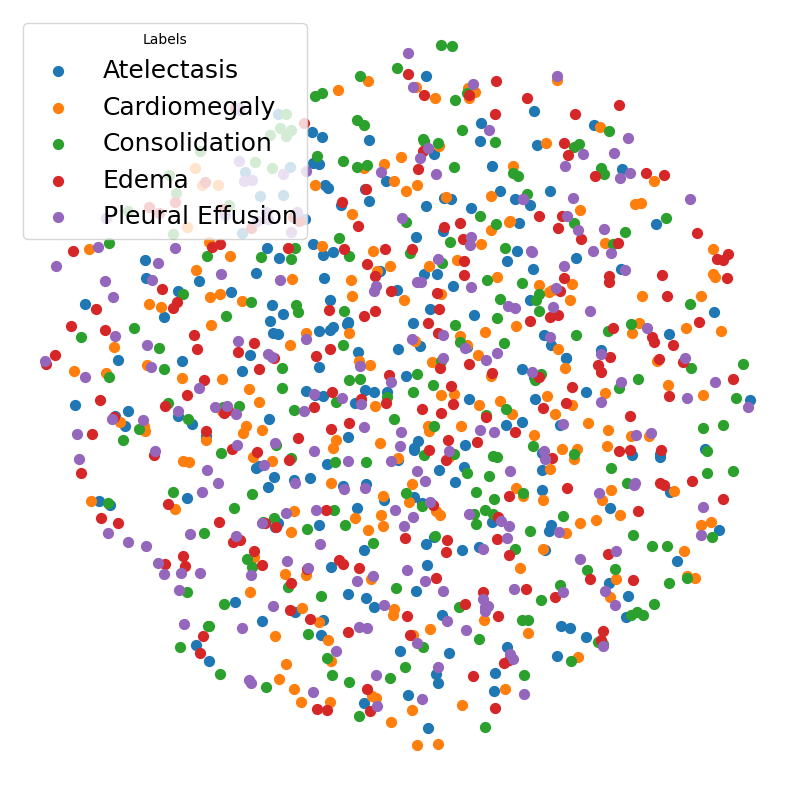

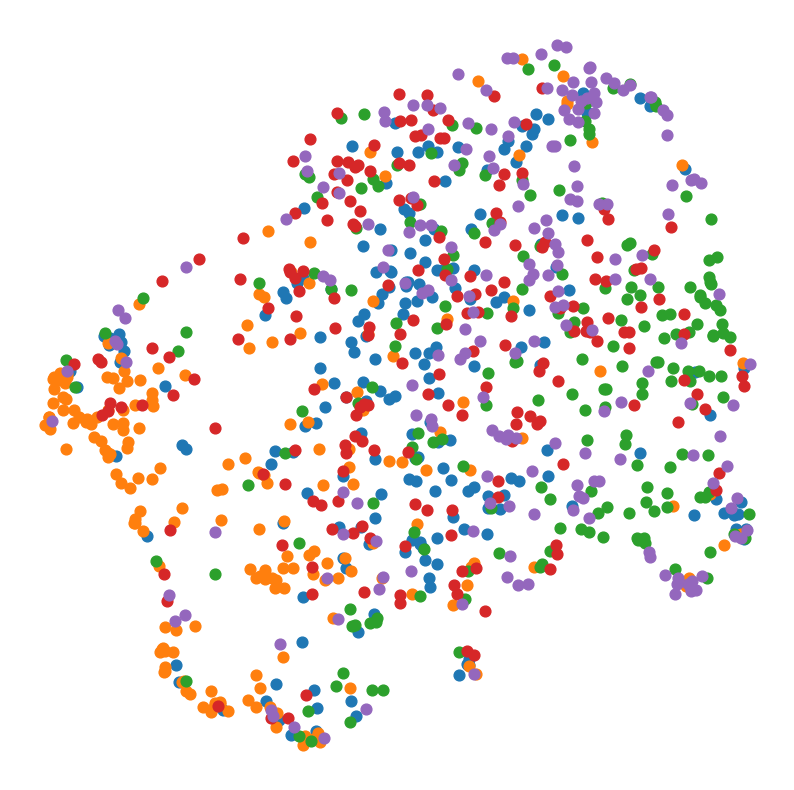

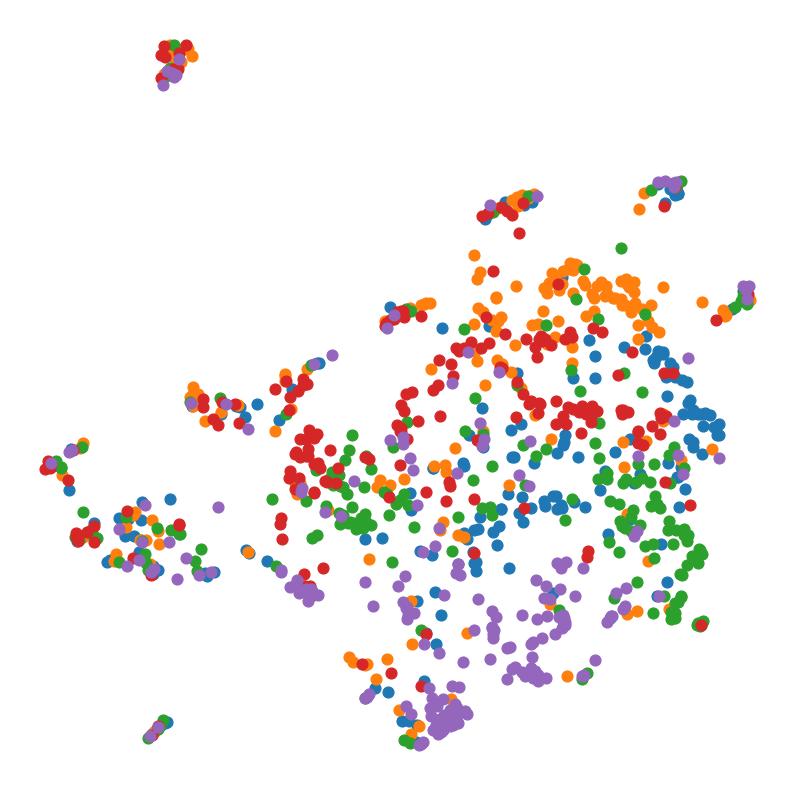

In [1]:
# vis tsne
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
seed=36
s=60
np.random.seed(seed)  # 设置随机种子为42
random_data = np.random.rand(1000, 256)
data=np.load(r'C:\Users\Alex\Desktop\result_rt.npy',allow_pickle=True)
data1=data.item().get('embeds_i')
data1=data1.mean(axis=1)
data2=data.item().get('embeds_t')
# data2=data.max(axis=1)
labels = np.array([i for i in range(5) for _ in range(200)])
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# tsne = TSNE(n_components=2, random_state=seed,perplexity=50,init='pca',n_iter=7000,learning_rate=2000)  # 设置随机种子为42
tsne = umap.UMAP(n_components=2, random_state=seed, n_neighbors=13, metric='euclidean')
data_tsne1 = tsne.fit_transform(data1)
data_tsne2 = tsne.fit_transform(data2)
random_tsne = tsne.fit_transform(random_data)

# 可视化随机初始化数据的 t-SNE
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.scatter(random_tsne[labels == i, 0], random_tsne[labels == i, 1], label=class_names[i],s=s-10)
plt.legend(title='Labels', loc='upper left',fontsize=18)
plt.axis('off')
plt.show()

# 可视化
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.scatter(data_tsne1[labels == i, 0], data_tsne1[labels == i, 1], label=class_names[i],s=s)
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.scatter(data_tsne2[labels == i, 0], data_tsne2[labels == i, 1], label=class_names[i],s=s)
plt.axis('off')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example 3x3 matrix
matrix = np.array([
    [0.78, 0.30, 0.31],
    [0.29, 0.85, 0.44],
    [0.34, 0.53, 0.96]
]).transpose()
# normalize the matrix on dimension 1
matrix = matrix / matrix.sum(axis=1, keepdims=True)

# Create heatmap
plt.figure(figsize=(6, 5))
heatmap = plt.imshow(matrix, cmap='Blues', interpolation='nearest')

# Annotate each cell with the numeric value in black
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, f"{matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=24)

# Hide the axes
plt.axis('off')
plt.show()